In [3]:
import pandas as pd
import numpy as np
import neattext.functions as nfx
import emoji
import re
import seaborn as sns

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,Text,Emotion
0,a few monthe ago,neutral
1,a friend of mine goes out with this guy she sl...,happy
2,a girl entered in the division where i work an...,neutral
3,about the car sadness i felt anger the way i a...,sad
4,after the funeral of an acquaintance i felt ve...,sad


In [4]:
df['Emotion'].value_counts()

neutral    1000
happy      1000
sad        1000
angry       999
Name: Emotion, dtype: int64

<AxesSubplot:xlabel='Emotion', ylabel='count'>

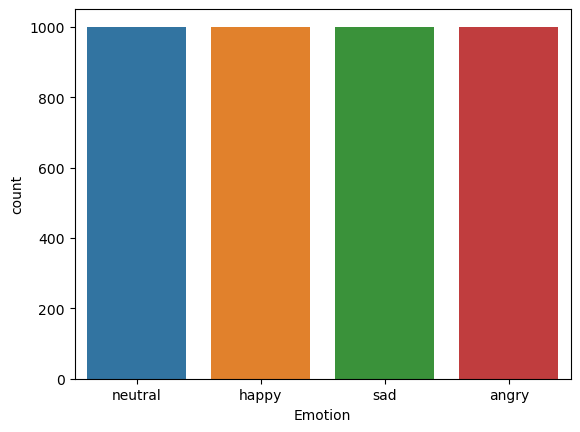

In [5]:
sns.countplot(x='Emotion',data=df)

In [6]:
# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Function to remove special Characters
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

column_to_clean = 'Text'

# Convert to string, remove emojis, then special characters
df[column_to_clean] = df[column_to_clean].astype(str)
df[column_to_clean] = df[column_to_clean].apply(remove_emojis)
df[column_to_clean] = df[column_to_clean].apply(remove_special_characters)

# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)

print("Cleaning complete. File saved as 'cleaned_data.csv'.")

Cleaning complete. File saved as 'cleaned_data.csv'.


In [7]:
# Load the file Cleaned_data.csv
df = pd.read_csv("cleaned_data.csv")

text_column = 'Text'

# Replace empty strings or whitespace-only cells with NaN
df[text_column] = df[text_column].replace(r'^\s*$', pd.NA, regex=True)

# Drop rows where Text is NaN
df = df.dropna(subset=[text_column])

# Save to a new CSV file
df.to_csv("cleaned_data_no_empty_rows.csv", index=False)

print("Empty rows in the 'Text' column have been removed and saved to 'cleaned_data_no_empty_rows.csv'.")

Empty rows in the 'Text' column have been removed and saved to 'cleaned_data_no_empty_rows.csv'.


In [4]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SaJiTh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Load the cleaned CSV
df = pd.read_csv("cleaned_data_no_empty_rows.csv")

text_col = 'Text'

def preprocess(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
df[text_col] = df[text_col].astype(str).apply(preprocess)

# Remove empty rows (after cleaning)
df = df[df[text_col].str.strip() != '']

# Save to new CSV
df.to_csv("preprocessed_data.csv", index=False)

print("Preprocessed text saved to 'preprocessed_data.csv'.")

Preprocessed text saved to 'preprocessed_data.csv'.


In [10]:
df = pd.read_csv("preprocessed_data.csv")

In [11]:
df.head()

,Text,Emotion
0,monthe ago,neutral
1,friend mine goes guy sleeps quite happy play a...,happy
2,girl entered division work greeted everybody,neutral
3,car sadness felt anger way acted negotiating,sad
4,funeral acquaintance felt depressed feeling tu...,sad


In [12]:
df['Emotion'].value_counts()

neutral    1000
happy      1000
sad        1000
angry       999
Name: Emotion, dtype: int64

In [13]:
# Load data
df = pd.read_csv("preprocessed_data.csv")

# Drop duplicates based only on the 'Text' column
df = df.drop_duplicates(subset='Text', keep='first')

# Save the cleaned data
df.to_csv("preprocessed_no_duplicates.csv", index=False)

print("Duplicates removed based on 'Text'. Saved to 'preprocessed_no_duplicates.csv'.")

Duplicates removed based on 'Text'. Saved to 'preprocessed_no_duplicates.csv'.


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

In [6]:
# Load preprocessed CSV with 'Text' and 'Emotion' columns
data = pd.read_csv('preprocessed_no_duplicates.csv')

print(f"Dataset size: {len(data)}")
print(data.head())

Dataset size: 3948
                                                Text  Emotion
0                                         monthe ago  neutral
1  friend mine goes guy sleeps quite happy play a...    happy
2       girl entered division work greeted everybody  neutral
3       car sadness felt anger way acted negotiating      sad
4  funeral acquaintance felt depressed feeling tu...      sad


In [7]:
# Define mapping based on emotion categories
emotion_map = {'happy': 0, 'sad': 1, 'angry': 2, 'neutral': 3}

# Map emotions to numeric labels
data['label'] = data['Emotion'].map(emotion_map)

# Check for unmapped labels (NaN) and drop them if any
print(f"Unmapped labels count: {data['label'].isnull().sum()}")
data = data.dropna(subset=['label'])

data['label'] = data['label'].astype(int)

Unmapped labels count: 0


In [8]:
X = data['Text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 3158, Test samples: 790


In [9]:
max_words = 40000
max_length = 100   

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of ints
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [10]:
num_classes = 4  # Happy, Sad, Angry, Neutral

y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

In [11]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    X_train_pad,
    y_train_ohe,
    validation_split=0.1,
    epochs=10,
    batch_size=50
)

Epoch 1/10
57/57 [==============================] - 3s 39ms/step - loss: 1.3866 - accuracy: 0.2400 - val_loss: 1.3859 - val_accuracy: 0.2342
Epoch 2/10
57/57 [==============================] - 2s 36ms/step - loss: 1.3840 - accuracy: 0.2854 - val_loss: 1.3853 - val_accuracy: 0.2595
Epoch 3/10
57/57 [==============================] - 2s 36ms/step - loss: 1.3802 - accuracy: 0.3037 - val_loss: 1.3805 - val_accuracy: 0.4241
Epoch 4/10
57/57 [==============================] - 2s 38ms/step - loss: 1.3729 - accuracy: 0.3642 - val_loss: 1.3723 - val_accuracy: 0.3576
Epoch 5/10
57/57 [==============================] - 2s 39ms/step - loss: 1.3530 - accuracy: 0.3951 - val_loss: 1.3502 - val_accuracy: 0.4019
Epoch 6/10
57/57 [==============================] - 2s 39ms/step - loss: 1.3081 - accuracy: 0.4736 - val_loss: 1.3097 - val_accuracy: 0.4241
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 1.2299 - accuracy: 0.5211 - val_loss: 1.2346 - val_accuracy: 0.4272
Epoch 8/10
57

In [14]:
loss, accuracy = model.evaluate(X_test_pad, y_test_ohe)
print(f"Test Accuracy: {accuracy:.4f}")

25/25 [==============================] - 0s 1ms/step - loss: 0.9534 - accuracy: 0.7949
Test Accuracy: 0.7949


In [24]:
def predict_emotion(text):
    """
    Predicts the emotion category for a single text string.
    """
    # Convert text to sequence using trained tokenizer
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(pad)
    # Map prediction index back to emotion label
    emotion_label = list(emotion_map.keys())[pred.argmax()]
    return emotion_label

# Example usage
sample_text = "I'm feeling amazing today! Everything is going so well!"
print("Text:", sample_text)
print("Predicted emotion:", predict_emotion(sample_text))

Text: I'm feeling amazing today!
1/1 [==============================] - 0s 15ms/step
Predicted emotion: happy
